### Download Libaray

In [317]:
# Watermark: IPython magic extension for printing date and time stamps, version numbers, and hardware information
!pip install -q -U watermark
# Transformer: State-of-the-art Natural Language Processing for PyTorch and TensorFlow 2.0
# !pip install transformers==2.11.0

# Print out key libraries' versions 
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

# columnize: Format a simple (i.e., not nested) list into aligned columns
# !pip install columnize


CPython 3.7.7
IPython 7.16.1

numpy 1.19.1
pandas 1.0.5
torch 1.6.0
transformers 2.11.0


In [564]:
# Keras is an open-source library that provides a Python interface for artificial neural networks.
# Keras acts as an interface for the TensorFlow library.
!pip install keras
!pip install tensorflow
!pip install tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


### Import Library

In [565]:
import os
# util library
import ast
import emoji 
import random

from nltk.tokenize.casual import TweetTokenizer

# ML/NLP/NLU library
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Data Analytics library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv

# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

### Common Setup

In [567]:
# GCU
import keras
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.debugging.set_log_device_placement(True)
tf.config.experimental.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8952338029809798545
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7395397110792478664
physical_device_desc: "device: XLA_CPU device"
]


[]

In [568]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)


In [319]:
# Visualization Config 
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 10

# PyTorch Config 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

# Pandas Config
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [320]:
DATA_DIR = './data'
print(os.listdir(DATA_DIR))

['tweet_emoji_dev_10000.csv', 'tweet_emoji_train_200000.csv', '.DS_Store', 'dev.txt', 'train.txt', 'glove.6B.50d.txt', 'dev.txt.zip', 'train.txt.zip', 'test.txt.zip', 'test.txt']


### Exploratory Data Analysis

In [569]:
df = pd.read_csv(os.path.join(DATA_DIR, 'tweet_emoji_train_800000.csv'))
# df = df.head(10000)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   tweet   10000 non-null  object
 2   emoji   10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


,id,tweet,emoji
0,0,CeeC is going to be another Tboss What is 45 million Naira,{'face_with_tears_of_joy'}
1,1,This gif kills me Death is literally gushing towards you and you really gon do a whole 3point turn,{'weary_face'}
2,2,LOVE TEST Raw Real JaDine,{'purple_heart'}
3,3,i swear we dont gotta look it finds us,{'face_with_tears_of_joy'}
4,4,We would like to wish everyone a very Happy New Year and all the best in 2018,{'party_popper'}


In [570]:
# Drop id column
df = df.drop('id', 1) 
# Drop duplicated tweet (for example: thank you)
df = df.drop_duplicates(subset=['tweet'], keep=False) 
df.info()
# Drop any sample with null attribute
df = df.dropna(how='any',axis=0)  
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9402 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   9402 non-null   object
 1   emoji   9402 non-null   object
dtypes: object(2)
memory usage: 220.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9402 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   9402 non-null   object
 1   emoji   9402 non-null   object
dtypes: object(2)
memory usage: 220.4+ KB


,tweet,emoji
0,CeeC is going to be another Tboss What is 45 million Naira,{'face_with_tears_of_joy'}
2,LOVE TEST Raw Real JaDine,{'purple_heart'}
4,We would like to wish everyone a very Happy New Year and all the best in 2018,{'party_popper'}
5,15000 retweets a new song song off Swaecation part 2 of unforgettable go,{'speaking_head'}
6,just know ilysm k bye friend,{'purple_heart'}


In [571]:
# Convert column "emoji" to "set", so duplicated emoji will be removed 
df['emoji'] = df['emoji'].apply(lambda x: set(ast.literal_eval(x))) 
# Then convert column "emoji" to "list", so it is hashable 
df.emoji= df.emoji.apply(list)
# Peek the head and see if dataframe transformation is working as expected 
df.head(10)

,tweet,emoji
0,CeeC is going to be another Tboss What is 45 million Naira,[face_with_tears_of_joy]
2,LOVE TEST Raw Real JaDine,[purple_heart]
4,We would like to wish everyone a very Happy New Year and all the best in 2018,[party_popper]
5,15000 retweets a new song song off Swaecation part 2 of unforgettable go,[speaking_head]
6,just know ilysm k bye friend,[purple_heart]
7,Too glam to give a damn,[sparkles]
8,fuck that sicko,[clapping_hands]
9,Can I marry someone who understands all these memes,[loudly_crying_face]
12,theyre 14 so i mean,"[female_sign, person_shrugging]"
13,Your artist got a dope sound my boy runs DM them this song for a post,[fire]


In [572]:
# helper functions to get the distinct emoji in the dataset
def get_distinct_emoji(emoji_column:pd.core.series.Series)->set:
    emoji_set = set()
    for emojis in emoji_column:
        for x in emojis: 
            emoji_set.add(x)
    return emoji_set

def format_emoji(e):
    return emoji.emojize(':'+ e +':')

def print_distinct_emoji_in_dataset(emoji_set:list, displaywidth=10):
    print('Total distinct count of Emojis in dataset is : {}'.format(len(emoji_set)))
    emoji_set_formatted = [format_emoji(e) for e in emoji_set]
    display = ''
    for i, e in enumerate(emoji_set_formatted):
        display += e + ' '
        if (i + 1) % displaywidth == 0:
            display = display + '\n'
    print(display)

# Gets the distinct emoji from dataset to be used for building the emoji multiclass classifier 
emoji_class = get_distinct_emoji(df.emoji)
print_distinct_emoji_in_dataset(sorted(list(emoji_class)))

Total distinct count of Emojis in dataset is : 49
👌 👇 👉 😁 💙 👏 💥 😢 ‼ 👀 
😘 🙄 😂 ♀ 🔥 💪 😳 🙏 🌟 ♥ 
✔ 💯 😭 ♂ 🎉 🤦 🤷 🚨 💜 🙌 
❤ ➡ 🤣 💀 ☺ 😍 😊 😎 ✨ 💖 
🗣 🤔 👍 🏆 💕 😩 ✅ 😉 💛 


In [573]:
# Since most of the tweets in the dataset only contain one emoji, we will build a multiclass classifier
# instead of building a multilable classifier 

# So, we will build a multiclass dataset with tweets which only contain one emoji 
df_multiclass_dataset = df[df['emoji'].apply(lambda x: len(x)==1)].copy()
# Create a column "label", to save the emoji info for each tweet in the dataset
df_multiclass_dataset['label'] = df_multiclass_dataset['emoji'].apply(lambda x: x[0])
df_multiclass_dataset.head()
df_multiclass_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8244 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   8244 non-null   object
 1   emoji   8244 non-null   object
 2   label   8244 non-null   object
dtypes: object(3)
memory usage: 257.6+ KB


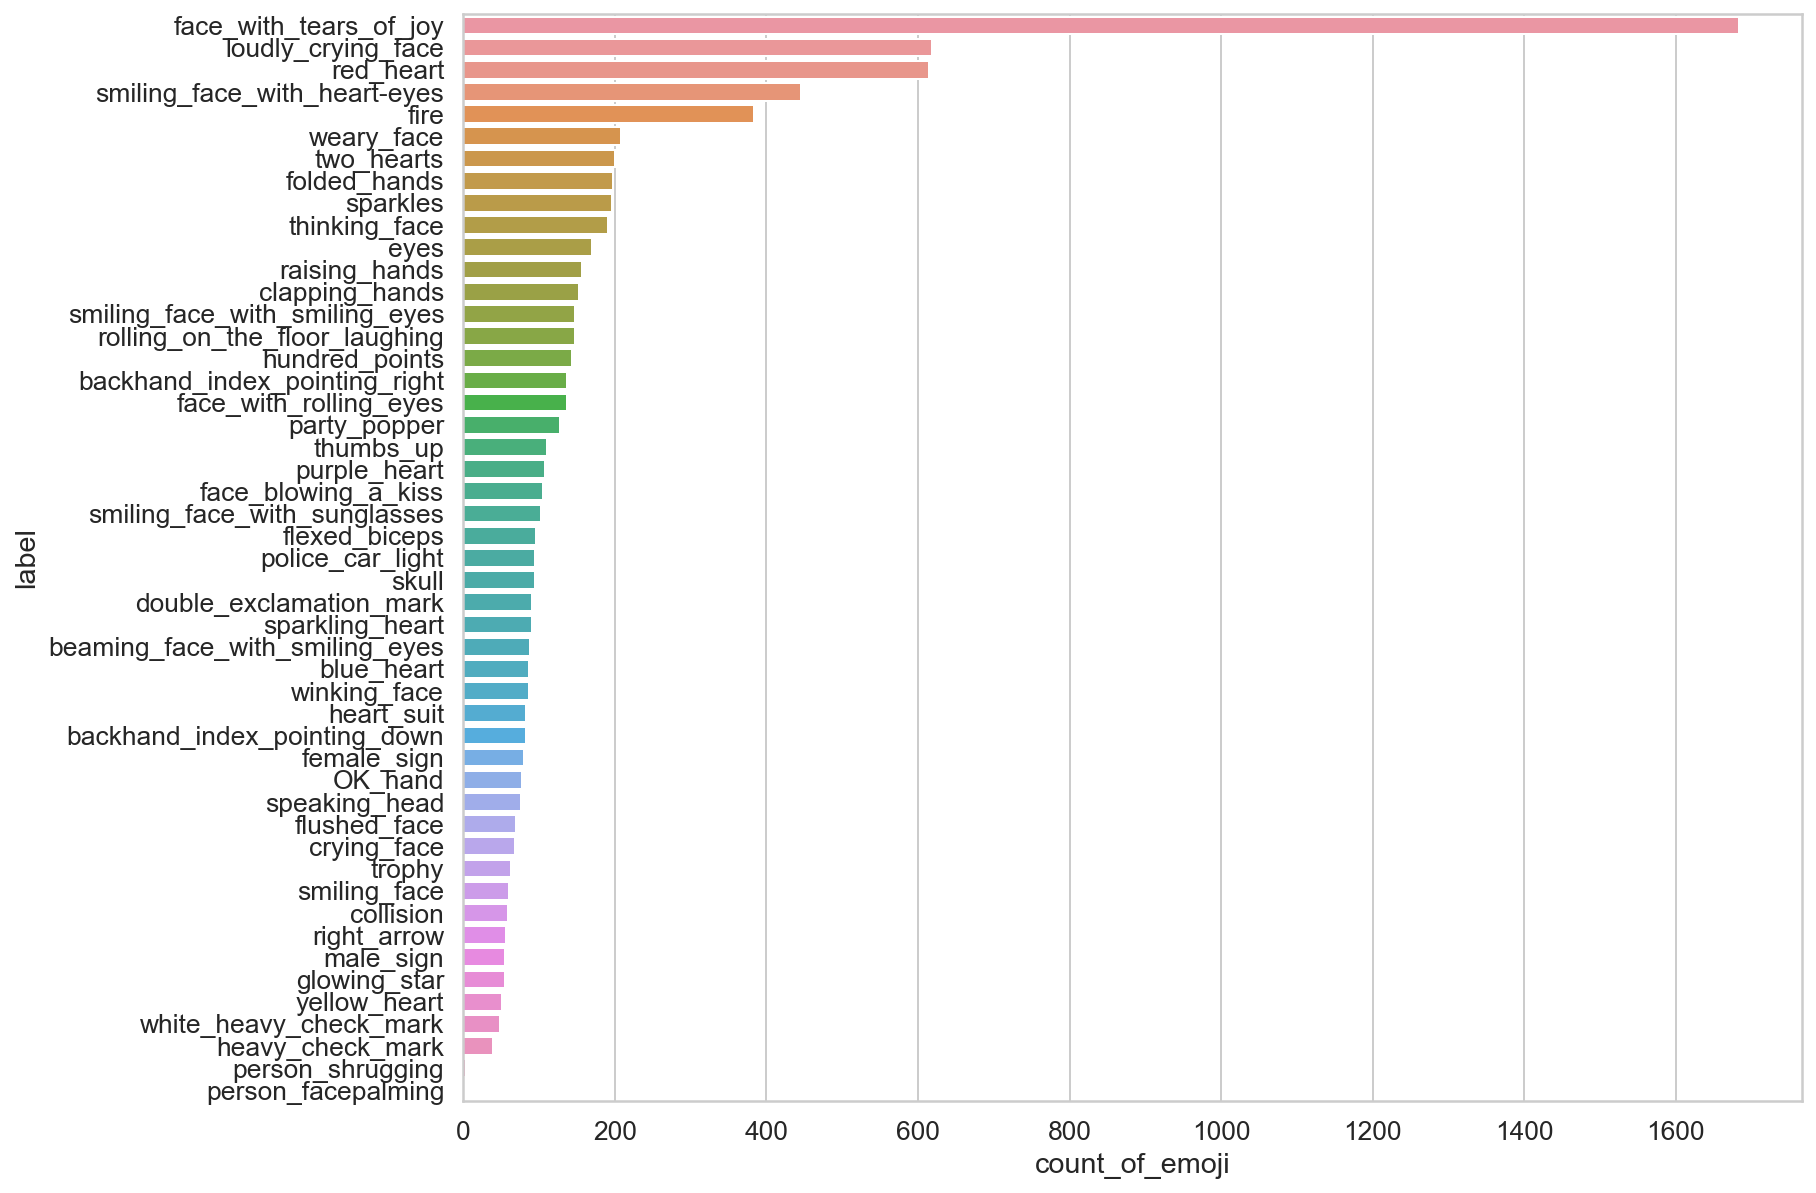

In [574]:
# Print out the count of each class (e.g., each emoji) in the dataset
order = df_multiclass_dataset['label'].value_counts(ascending=False).index
sns.countplot(y="label", data=df_multiclass_dataset, order=order)
plt.xlabel('count_of_emoji');

In [575]:
df_multiclass_dataset['label'].unique()

array(['face_with_tears_of_joy', 'purple_heart', 'party_popper',
       'speaking_head', 'sparkles', 'clapping_hands',
       'loudly_crying_face', 'fire', 'hundred_points', 'red_heart',
       'raising_hands', 'smiling_face_with_heart-eyes', 'trophy',
       'weary_face', 'beaming_face_with_smiling_eyes',
       'backhand_index_pointing_down', 'two_hearts', 'heart_suit',
       'male_sign', 'thumbs_up', 'folded_hands', 'flexed_biceps',
       'face_blowing_a_kiss', 'smiling_face', 'face_with_rolling_eyes',
       'crying_face', 'police_car_light', 'OK_hand', 'blue_heart',
       'winking_face', 'flushed_face', 'white_heavy_check_mark',
       'female_sign', 'smiling_face_with_sunglasses',
       'double_exclamation_mark', 'smiling_face_with_smiling_eyes',
       'thinking_face', 'backhand_index_pointing_right', 'collision',
       'rolling_on_the_floor_laughing', 'yellow_heart', 'skull', 'eyes',
       'right_arrow', 'sparkling_heart', 'glowing_star',
       'heavy_check_mark', 'perso

In [595]:
emoji_class = ['face_with_tears_of_joy',
               'red_heart',
               'loudly_crying_face',
               'smiling_face_with_heart-eyes', 
               'fire', 
               'weary_face', 
               'thinking_face', 
               'folded_hands', 
               'two_hearts', 
               'smiling_face_with_smiling_eyes',
               'sparkles', 
               'raising_hands', 
               'eyes', 
               'face_with_rolling_eyes',
               'hundred_points', 
               'rolling_on_the_floor_laughing',
               'clapping_hands', 
               'thumbs_up', 
               'face_blowing_a_kiss', 
               'party_popper',
              ]
print_distinct_emoji_in_dataset(emoji_class)
df_multiclass_sub_dataset = df_multiclass_dataset[df_multiclass_dataset['label'].isin(emoji_class)]

# SAMPLE_SIZE = 11000
# df_multiclass_dataset_balanced=df_multiclass_sub_dataset.groupby('label', as_index=False, group_keys=False)\
# .apply(lambda s: s.sample(SAMPLE_SIZE, replace=True))

# Samples equal size of each class with sample size as the size of the class with minimum number of data.
g = df_multiclass_sub_dataset.groupby('label', as_index=False, group_keys=False)

# df_multiclass_dataset_balanced_min = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
print(g.size().min(), int(g.size().median()), g.size().max())

SAMPLE_SIZE=int(g.size().median())
df_multiclass_dataset_balanced_median = g.apply(
    lambda x: x.sample(SAMPLE_SIZE, replace=x.index.size<SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True))

print(df_multiclass_dataset_balanced_median['label'].value_counts())

Total distinct count of Emojis in dataset is : 20
😂 ❤ 😭 😍 🔥 😩 🤔 🙏 💕 😊 
✨ 🙌 👀 🙄 💯 🤣 👏 👍 😘 🎉 

105 180 1683
thumbs_up                         180
fire                              180
loudly_crying_face                180
smiling_face_with_smiling_eyes    180
weary_face                        180
thinking_face                     180
clapping_hands                    180
smiling_face_with_heart-eyes      180
face_with_tears_of_joy            180
two_hearts                        180
face_blowing_a_kiss               180
eyes                              180
face_with_rolling_eyes            180
party_popper                      180
raising_hands                     180
sparkles                          180
folded_hands                      180
hundred_points                    180
rolling_on_the_floor_laughing     180
red_heart                         180
Name: label, dtype: int64


In [600]:
# Dedup
# Drop duplicated tweet (for example: thank you)
df_multiclass_dataset_balanced = df_multiclass_dataset_balanced_median.drop_duplicates(subset=['tweet'], keep=False).copy() 

In [601]:
print(df_multiclass_dataset_balanced['label'].value_counts())

folded_hands                      180
fire                              180
red_heart                         180
two_hearts                        180
loudly_crying_face                180
face_with_tears_of_joy            180
weary_face                        180
smiling_face_with_heart-eyes      180
sparkles                          180
thinking_face                     180
eyes                               52
raising_hands                      51
clapping_hands                     47
smiling_face_with_smiling_eyes     45
rolling_on_the_floor_laughing      45
hundred_points                     44
party_popper                       41
face_with_rolling_eyes             40
thumbs_up                          34
face_blowing_a_kiss                31
Name: label, dtype: int64


### Generate Text Embeddings and Label Categorical

#### Label Categorical

In [602]:
label_encoder = preprocessing.LabelEncoder()
df_multiclass_dataset_balanced['target'] = label_encoder.fit_transform(df_multiclass_dataset_balanced['label'])
df_multiclass_dataset_balanced.reset_index(inplace=True) # reset the index 
# rename the index to use name "id"
df_multiclass_dataset_balanced.index.rename('id', inplace=True) 
# drop the redundant index column and only use the "id" column
df_multiclass_dataset_balanced = df_multiclass_dataset_balanced.drop('index', 1)

emoji_class = list(label_encoder.classes_)

In [603]:
print(emoji_class)
df_multiclass_dataset_balanced.head()

['clapping_hands', 'eyes', 'face_blowing_a_kiss', 'face_with_rolling_eyes', 'face_with_tears_of_joy', 'fire', 'folded_hands', 'hundred_points', 'loudly_crying_face', 'party_popper', 'raising_hands', 'red_heart', 'rolling_on_the_floor_laughing', 'smiling_face_with_heart-eyes', 'smiling_face_with_smiling_eyes', 'sparkles', 'thinking_face', 'thumbs_up', 'two_hearts', 'weary_face']


,tweet,emoji,label,target
id,,,,
0,EARTH SHAKING POPULAR BOY BAND EXO,[clapping_hands],clapping_hands,0
1,Saat ini menjadi Trending Worldwide no5 dengan 647K tweets Thank youu for those precio,[clapping_hands],clapping_hands,0
2,It was the accurate nose,[clapping_hands],clapping_hands,0
3,Here comes the Birthday boy Saengil chukhaeyo hoseokah When theres a HOPE there is JHOPEEEyoongis,[clapping_hands],clapping_hands,0
4,TRUMP ISNT THE LEGISLATIVE BRANCH OF THE GOVERNMENT,[clapping_hands],clapping_hands,0


In [604]:
df_train, df_test = train_test_split(df_multiclass_dataset_balanced, 
                                     test_size=0.1,
                                     random_state=RANDOM_SEED, 
                                     stratify=df_multiclass_dataset_balanced['label'])

x_train = df_train['tweet']
y_train = df_train['target']
# From category number to one-host representation.
y_train_category = to_categorical(y_train)

x_test = df_test['tweet']
y_test = df_test['target']
y_test_category = to_categorical(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2007,) (2007,)
(223,) (223,)


In [605]:
count = 0
display_size = 5
print('Tweet texts:')
for i in x_train.head():
    print(i)

print('Category number:')
for i in y_train.head():
    print(i)

print('Catagory one-hot representation:')
for i in y_train_category:
    if count >= display_size:
        break
    count += 1
    print(i)

Tweet texts:
Yall got me fucked up
Omg you know i dont do that to you anymore
Hes 9 and more of a man than all my exs Read the caption amp youll understand why ht
When nigga touching you thats not ya nigga
When Drake said Fuck a fake friend where my real friends at I felt that shit deep
Category number:
19
3
18
4
7
Catagory one-hot representation:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Text Embedding

In [606]:
def glove2dict(src_filename):
    """
    GloVe vectors file reader.

    Parameters
    ----------
    src_filename : str
        Full path to the GloVe file to be processed.

    Returns
    -------
    dict
        Mapping words to their GloVe vectors as `np.array`.

    """
    # This distribution has some words with spaces, so we have to
    # assume its dimensionality and parse out the lines specially:
    if '840B.300d' in src_filename:
        line_parser = lambda line: line.rsplit(" ", 300)
    else:
        line_parser = lambda line: line.strip().split()
    data = {}
    with open(src_filename, encoding='utf8') as f:
        while True:
            try:
                line = next(f)
                line = line_parser(line)
                data[line[0]] = np.array(line[1: ], dtype=np.float)
            except StopIteration:
                break
            except UnicodeDecodeError:
                pass
    return data


def zerovec(n=50):
    return np.array([0] * n)


def randvec(n=50, lower=-0.5, upper=0.5):
    """
    Returns a random vector of length `n`. `w` is ignored.

    """

    return np.array([random.uniform(lower, upper) for i in range(n)])

In [607]:
GLOVE_HOME = os.path.join('data')
glove_lookup = glove2dict(
    os.path.join(GLOVE_HOME, 'glove.6B.50d.txt'))

In [608]:
glove_lookup.get('hello', zerovec(n=50))

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ])

In [609]:
glove_lookup.get('Hello', zerovec(n=50))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [610]:
# Exploratory analysis to determine the max_len used for padding tokens 
token_lens = []
tknzr = TweetTokenizer(preserve_case=False)

for txt in df_multiclass_dataset_balanced.tweet:
#     tokens = txt.split()
    tokens = tknzr.tokenize(txt)
    token_lens.append(len(tokens))

print('Num of tweets:', len(token_lens))

Num of tweets: 2230


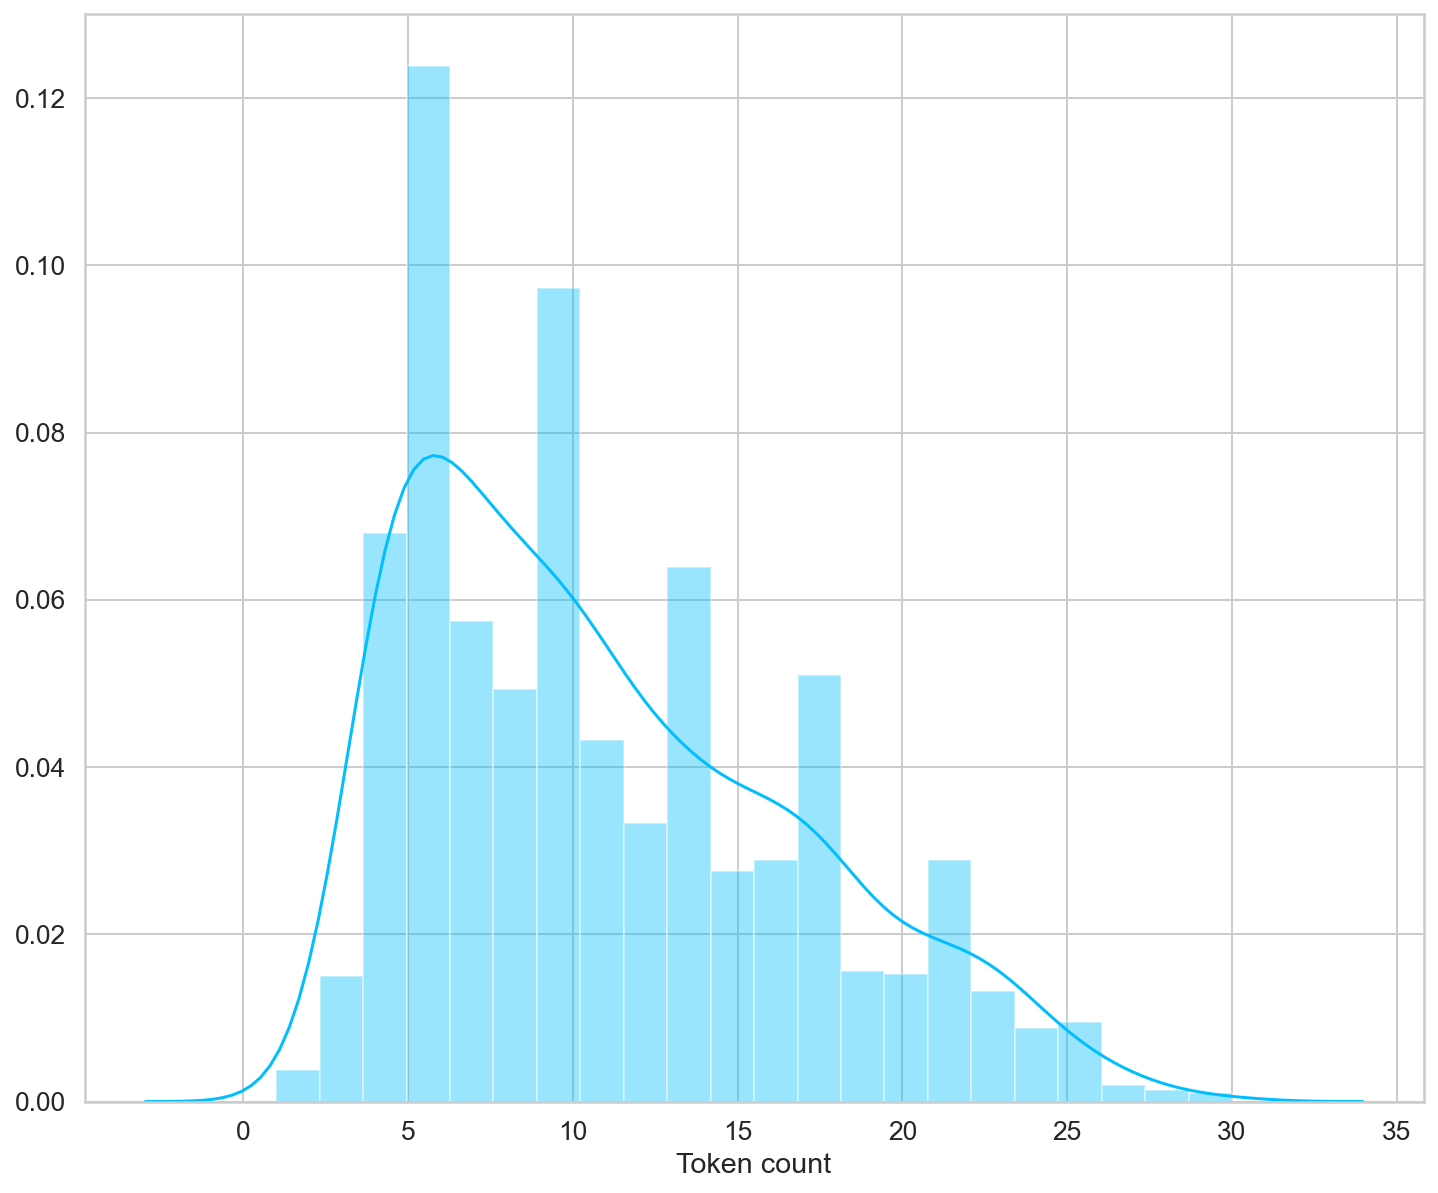

In [611]:
# Plots the token length distribution 
sns.distplot(token_lens)
plt.xlabel('Token count');

In [612]:
import random

# Set MAX_LEN used for padding tokens based on the exploratory analysis result 
MAX_LEN = 30
GLOVE_DIM = 50

tknzr = TweetTokenizer(preserve_case=False)

def get_tokens(txt, use_tweet_tokenizer=False):
    if use_tweet_tokenizer:
        return tknzr.tokenize(txt)
    return txt.split()

def get_embeddings(text_array):
    embeddings = np.zeros((len(text_array), MAX_LEN, GLOVE_DIM))
    for i in range(len(text_array)):
        tokens = get_tokens(text_array[i], use_tweet_tokenizer=True)
        for j in range(min(len(tokens), MAX_LEN)):
            emb = glove_lookup.get(tokens[j].lower())
            if emb is None:
                # print('Embedding not found for: ', tokens[j].lower())
                emb = randvec(n=GLOVE_DIM)
            embeddings[i][j] = emb
    return embeddings

In [613]:
tweets = ['We would like to wish everyone a very Happy New Year and all the best in 2018 htt',
          'ranks 6th in January Idol Group Brand Reputation 1Keep using 2Search GOT 7 on Naver htt']

for txt in tweets:
    print(get_tokens(txt))
    print(get_tokens(txt, use_tweet_tokenizer=True))

get_embeddings(tweets)

['We', 'would', 'like', 'to', 'wish', 'everyone', 'a', 'very', 'Happy', 'New', 'Year', 'and', 'all', 'the', 'best', 'in', '2018', 'htt']
['we', 'would', 'like', 'to', 'wish', 'everyone', 'a', 'very', 'happy', 'new', 'year', 'and', 'all', 'the', 'best', 'in', '2018', 'htt']
['ranks', '6th', 'in', 'January', 'Idol', 'Group', 'Brand', 'Reputation', '1Keep', 'using', '2Search', 'GOT', '7', 'on', 'Naver', 'htt']
['ranks', '6th', 'in', 'january', 'idol', 'group', 'brand', 'reputation', '1keep', 'using', '2search', 'got', '7', 'on', 'naver', 'htt']


array([[[ 0.57387 , -0.32729 ,  0.070521, ...,  0.48759 , -0.18439 ,
          0.69939 ],
        [ 0.7619  , -0.29773 ,  0.51396 , ...,  0.43088 , -0.22768 ,
          0.4026  ],
        [ 0.36808 ,  0.20834 , -0.22319 , ..., -0.67236 , -0.39709 ,
          0.25183 ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]],

       [[-0.80507 , -0.19595 ,  0.70291 , ..., -0.25731 , -0.34742 ,
         -0.28948 ],
        [-0.6281  ,  0.10793 , -0.20794 , ..., -0.90708 ,  0.091468,
          0.04511 ],
        [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
         -0.53285 ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
   

In [614]:
x_train_emb = get_embeddings(x_train.array)
x_test_emb = get_embeddings(x_test.array)

In [615]:
print(x_train_emb.shape)
print(y_train_category.shape)
print(x_train_emb[0])
print(y_train_category[0])

print(x_test_emb.shape)
print(y_test_category.shape)

(2007, 30, 50)
(2007, 20)
[[-0.73151   0.0294    1.1246   ...  0.31029   0.83963   1.4186  ]
 [-0.4097   -0.37167   0.38852  ... -0.25414   0.040372  0.38652 ]
 [-0.14525   0.31265   0.15184  ... -0.50895   0.14322   1.0118  ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(223, 30, 50)
(223, 20)


### Imbalance Processing: SMOTE

In [619]:
!pip install imbalanced-learn

     |████████████████████████████████| 167 kB 1.3 MB/s eta 0:00:01


In [623]:
# # TODO: expolore imblanced sampling and training
from imblearn.over_sampling import SMOTE

print((x_train_emb.shape, y_train_category.shape))

# Found array with dim 3. Estimator expected <= 2.
# reshape two 2d and convert back later.
x_train_emb_reshape = x_train_emb.reshape(-1, MAX_LEN * GLOVE_DIM)

oversample = SMOTE()
X, y = oversample.fit_resample(x_train_emb_reshape, y_train_category)

# Convert back
X = X.reshape(-1, MAX_LEN, GLOVE_DIM)

print((X.shape, y.shape))

x_train_emb_smote, y_train_category_smote = X, y

((2007, 1500), (2007, 20))
((3240, 30, 50), (3240, 20))


/Users/han/devel/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Model Development LSTM

#### Model Training

In [624]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout, Bidirectional

In [625]:
model = Sequential()
model.add(Bidirectional(LSTM(units=512, return_sequences=True), input_shape=(MAX_LEN, GLOVE_DIM)))
model.add(Dropout(0.2))  # was 0.3
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.2))  # was 0.3
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
# Multi-class classification, y has to be one-hot-encoded use keras.utils.to_categorical.
model.add(Dense(units=len(emoji_class), activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 30, 1024)          2306048   
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 1024)          0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 512)               2623488   
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 32)               

In [626]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])


In [ ]:
%%time

EPOCHS = 20
BATCH_SIZE = 64
BEST_MODEL_WEIGHT_FILE_PATH = 'lstm-best-model.hdf5'
# Early stopping if the loss is no longer decreasing for <patience> epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
model_check_point_save = ModelCheckpoint(filepath=BEST_MODEL_WEIGHT_FILE_PATH, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')

hist = model.fit(x_train_emb_smote, 
                 y_train_category_smote, 
                 validation_split=0.1, 
                 shuffle=True, 
                 batch_size=BATCH_SIZE, 
                 epochs=EPOCHS,
                 callbacks=[early_stopping, model_check_point_save, reduce_lr_loss],
                )

Epoch 1/20
42/46 [==========================>...] - ETA: 15s - loss: 2.9812 - accuracy: 0.0681

In [ ]:
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [ ]:
# Load the best weights, check scores, and predict values.
model.load_weights(filepath=BEST_MODEL_WEIGHT_FILE_PATH)

loss, accuracy = model.evaluate(x_test_emb, y_test_category)
print('    loss:', loss)
print('accuracy:', accuracy)

In [554]:
def get_predictions(model, dataset):
    tweets = dataset['tweet']
    # String of emoji class
    emoji_labels = dataset['label']
    embeddings = get_embeddings(tweets.array)
    preds = model.predict(embeddings)
    # Convert probability matrix to category number with max prodbablity.
    pred_catagories = np.argmax(preds, axis=1)
    pred_probs = preds.max(1)
    # Transform category number to emoji class string.
    pred_labels = label_encoder.inverse_transform(pred_catagories)
    
    return tweets, dataset['label'], dataset['target'], pred_labels, pred_catagories, pred_probs

tweets, emojis, category_num, pred_emojis, pred_category_num, pred_probs = get_predictions(model, df_test)

In [556]:
# precision, recall, f1-score, support.
print(classification_report(category_num, pred_category_num, target_names=list(emoji_class)))

                                precision    recall  f1-score   support

                clapping_hands       0.66      0.66      0.66      1100
                          eyes       0.59      0.62      0.60      1100
           face_blowing_a_kiss       0.61      0.62      0.61      1100
        face_with_rolling_eyes       0.61      0.58      0.60      1100
        face_with_tears_of_joy       0.19      0.24      0.21      1100
                          fire       0.51      0.49      0.50      1100
                  folded_hands       0.60      0.58      0.59      1100
                hundred_points       0.68      0.65      0.66      1100
            loudly_crying_face       0.35      0.27      0.30      1100
                  party_popper       0.78      0.82      0.80      1100
                 raising_hands       0.60      0.61      0.61      1100
                     red_heart       0.27      0.25      0.26      1100
 rolling_on_the_floor_laughing       0.57      0.56      0.56  

In [558]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

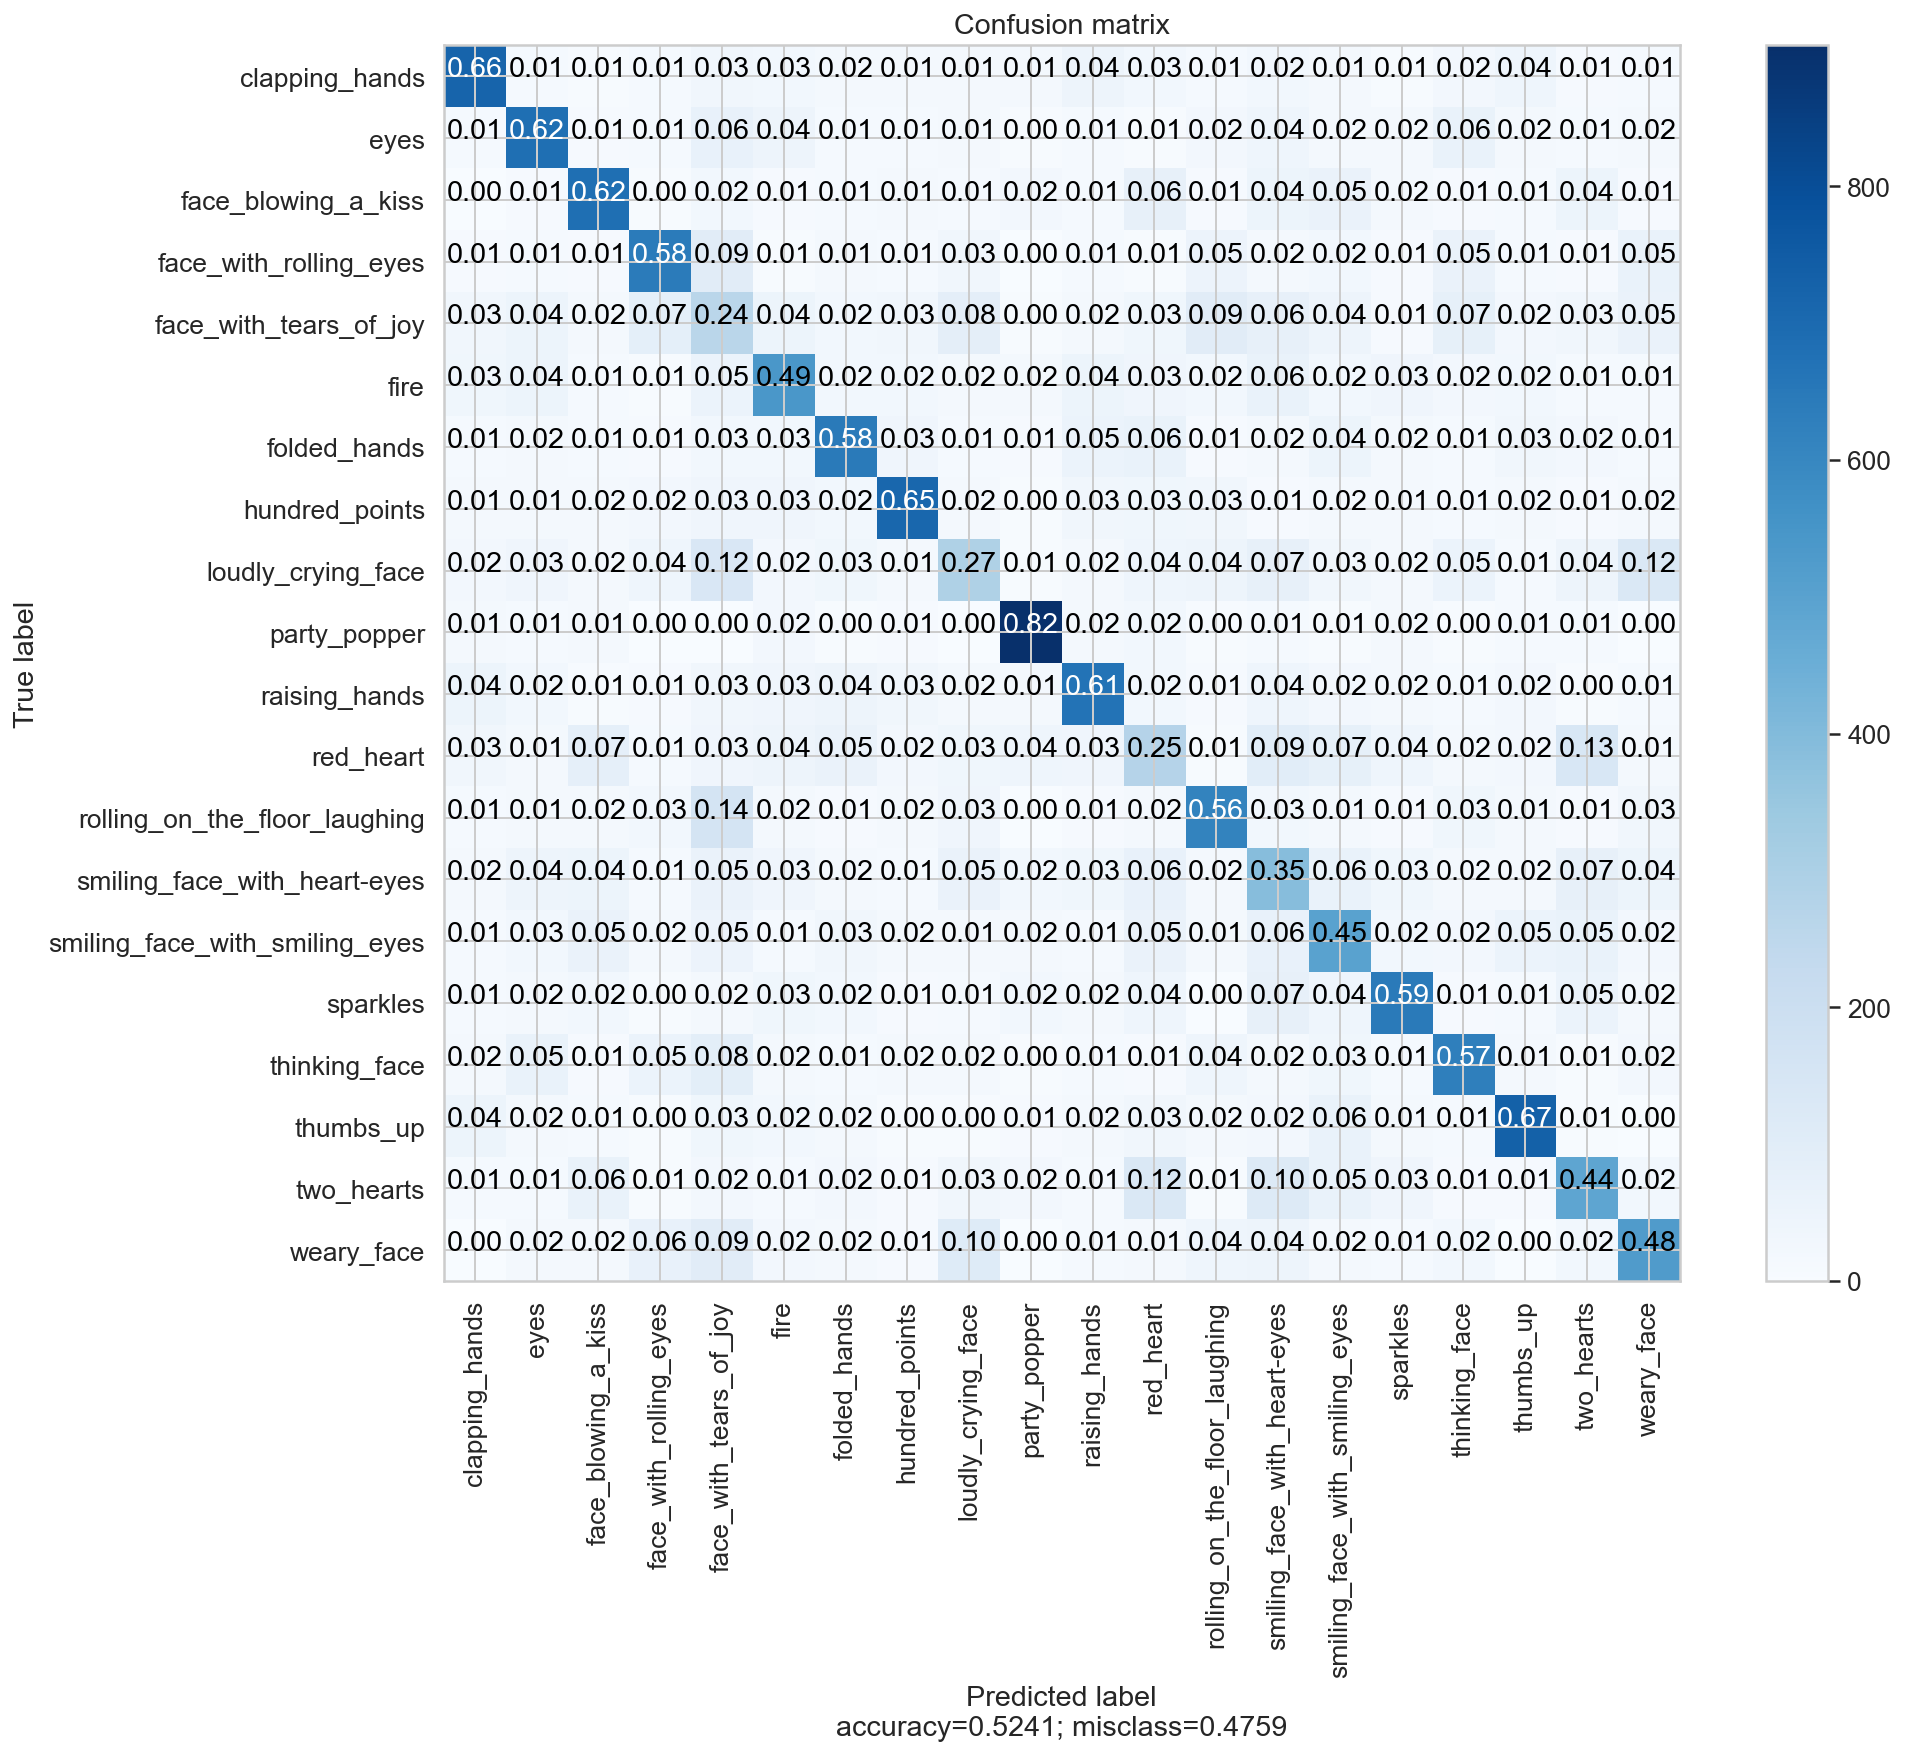

In [560]:
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

conf_matrix = confusion_matrix(y_true=category_num, y_pred=pred_category_num)

plot_confusion_matrix(conf_matrix, target_names=list(emoji_class))

In [561]:
df_prediction = pd.DataFrame(
    {'tweet_texts': tweets,
     'emojis': emojis,
     'predicted_emojis': pred_emojis,
     'predicted_probability': pred_probs,
    })

In [562]:
df_prediction['emojis'] = [emoji.emojize(':'+ e +':') for e in df_prediction['emojis'].values]
df_prediction['predicted_emojis'] = [emoji.emojize(':'+ e +':') for e in df_prediction['predicted_emojis'].values]

In [563]:
df_prediction.head(20)

,tweet_texts,emojis,predicted_emojis,predicted_probability
id,,,,
141091,Just wanna give someone smooth skin Best care right here,🤣,😂,0.265525
10242,Damn if this little girl was black,👏,😍,0.599861
159115,When Mark introduced himself credits to the owner http,😊,😊,0.582318
10160,I dont get this praise men seek for cooking Like bro well done Youre an adult who can feed himself,👏,👏,0.535241
17485,Met but he is a bit different in person London United Kingdom,👀,👀,0.978601
137555,just let the whole family debut,🤣,🤣,0.556015
203852,2018020 3 Princes in CARATLAND,💕,😂,0.380877
208978,Best feeling is when Im with you make me feel like a kid in school,💕,💯,0.451010
97048,You know how happy i am to see coco performed at the Grammys,😭,😭,0.891871
